# Hair Style Types Recognition using VGG16

# Import images from Kaggle

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kavyasreeb/hair-type-dataset")

print("Path to dataset files:", path)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /root/.cache/kagglehub/datasets/kavyasreeb/hair-type-dataset/versions/1


# Import Dependencies

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, Flatten, RandomHeight, RandomWidth, RandomZoom, RandomBrightness
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns
import matplotlib.pyplot as plt

I0000 00:00:1728973743.947152  967740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728973743.970891  967740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728973743.971258  967740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Reformat Images


In [3]:
from PIL import Image
import os

directory = path + '/data/'
# Check image types in the directory
image_types = set()
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff')):
            image_path = os.path.join(root, file)
            with Image.open(image_path) as img:
                if img.format == 'WEBP':
                    img = img.convert('RGB')
                    img.save(image_path, 'JPEG')
                image_types.add(img.format)

print("Image types in the directory:", image_types)

Image types in the directory: {'PNG', 'JPEG'}



## Dividing into Training and Testing set and importing and Obfuscating Images
We will import the necessary libraries and use `image_dataset_from_directory` from TensorFlow to create datasets for training and testing. This method will help in loading the images efficiently and applying data augmentation techniques to increase the diversity of the training data, thereby improving the robustness of the model.

In [4]:
training_set = image_dataset_from_directory(directory, 
                                                                   labels='inferred', 
                                                                   label_mode='categorical', 
                                                                   class_names=None, 
                                                                   color_mode='rgb',
                                                                   batch_size=32, 
                                                                   image_size=(128, 128), 
                                                                   shuffle=True, 
                                                                   seed=42, 
                                                                   validation_split=0.2, 
                                                                   subset='training', 
                                                                   interpolation='nearest',
                                                                   follow_links=False, 
                                                                   crop_to_aspect_ratio=False,
                                                                   pad_to_aspect_ratio=True,
                                                                   verbose=True
                                                                   ) 
testing_set = image_dataset_from_directory(directory, 
                                                                   labels='inferred', 
                                                                   label_mode='categorical', 
                                                                   class_names=None, 
                                                                   color_mode='rgb',
                                                                   batch_size=32, 
                                                                   image_size=(128, 128), 
                                                                   shuffle=True, 
                                                                   seed=42, 
                                                                   validation_split=0.2, 
                                                                   subset='validation', 
                                                                   interpolation='nearest',
                                                                   follow_links=False, 
                                                                   crop_to_aspect_ratio=False,
                                                                   pad_to_aspect_ratio=True,
                                                                   verbose=True
                                                                   ) 


Found 1988 files belonging to 5 classes.
Using 1591 files for training.


I0000 00:00:1728973748.598795  967740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728973748.599409  967740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728973748.601314  967740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728973748.807854  967740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728973748.808077  967740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 1988 files belonging to 5 classes.
Using 397 files for validation.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = training_set.prefetch(buffer_size=AUTOTUNE)
validation_dataset = testing_set.prefetch(buffer_size=AUTOTUNE)


# Exploring the Datasets

In this section, we will explore the training and testing datasets. We will visualize some sample images and their corresponding labels to understand the data distribution and the types of hairstyles present in the dataset. This will help us gain insights into the data and prepare for the model training process.

In [6]:
# Show the names of the labels in the training set
label_names = training_set.class_names
print("Label names in the training set:", label_names)

Label names in the training set: ['Straight', 'Wavy', 'curly', 'dreadlocks', 'kinky']


In [7]:
# Show the categorical labels of the training set
print("Categorical labels of the training set:", {i: label for i, label in enumerate(training_set.class_names)})


Categorical labels of the training set: {0: 'Straight', 1: 'Wavy', 2: 'curly', 3: 'dreadlocks', 4: 'kinky'}


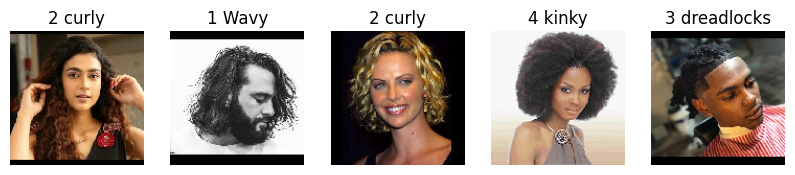

In [8]:

# Get a batch of images and labels
images, labels = next(training_set.as_numpy_iterator())

# Plot the first five images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title(str(np.argmax(labels[i])) + " " + training_set.class_names[np.argmax(labels[i])])
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# Model
We will use the VGG16 model with pretrained weights. Some layers will be unfrozen to allow fine-tuning.

In [9]:
checkpoint = ModelCheckpoint('RNNs/Tensorflow-Keras/Image Recognition/Type of haircut/best_model.weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True)

In [10]:


# Load the VGG16 model with pretrained weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Adjust the learning rate for fine-tuning
fine_tune_learning_rate = 1e-5

# Unfreeze some layers in the base model to allow fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Apply data augmentation to the training set
data_augmentation = Sequential([
    RandomHeight(0.3),
    RandomWidth(0.3),
    RandomZoom(0.3),
    RandomBrightness(0.3),
])

inputs = base_model.input
x = data_augmentation(inputs)
x = Dense(128, activation='relu')(base_model.output)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
predictions = Dense(len(training_set.class_names), activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=predictions)

# Model summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=fine_tune_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with reduced batch size
history = model.fit(training_set, validation_data=testing_set, epochs=40, batch_size=32, callbacks=[checkpoint])



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,928,581 (56.95 MB)

 Trainable params: 7,293,317 (27.82 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/40


I0000 00:00:1728973754.533126  967856 service.cc:146] XLA service 0x7ff234005d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728973754.533366  967856 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6


 3/50 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.2622 - loss: 15.3736

I0000 00:00:1728973762.138093  967856 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 312ms/step - accuracy: 0.2002 - loss: 8.8377 - val_accuracy: 0.2670 - val_loss: 2.0493
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.2372 - loss: 2.3052 - val_accuracy: 0.2897 - val_loss: 1.7092
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.3096 - loss: 1.7721 - val_accuracy: 0.3174 - val_loss: 1.6014
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.3695 - loss: 1.5799 - val_accuracy: 0.3401 - val_loss: 1.5330
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.4016 - loss: 1.4289 - val_accuracy: 0.3703 - val_loss: 1.4734
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.4629 - loss: 1.3257 - val_accuracy: 0.4055 - val_loss: 1.4138
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.5295 - loss: 1.1725 - val_accuracy: 0.4358 - val_loss: 1.3585
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.6078 - loss: 1.0399 - val_accuracy: 0.4458 - val_los

## Load model best weights
In this section, we will load the best model weights saved during training. This will allow us to use the model with the highest validation accuracy for making predictions on the testing set.

In [11]:
model.load_weights('RNNs/Tensorflow-Keras/Image Recognition/Type of haircut/best_model.weights.h5')

## Model Evaluation and Predictions

In this section, we will evaluate the model's performance on the testing set. We will load the best model weights saved during training to ensure we are using the most accurate model. Additionally, we will generate predictions on the testing set and compare them with the true labels. Finally, we will visualize the results using a confusion matrix to gain insights into the model's classification performance.

In [12]:
# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(testing_set)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


predicted_labels = []
true_labels = []
for images, labels in testing_set:
    preds = model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

print("Predicted labels:", predicted_labels)
print("True labels:", true_labels)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7311 - loss: 0.9536
Test accuracy: 72.29%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
Predicted labels: [3, 3, 2, 3, 1, 0, 2, 0, 1, 2, 4, 0, 2, 2, 4, 3, 2, 2, 2, 0, 0, 3, 0, 1, 1, 3, 2, 0, 3, 2, 3, 0, 3, 0, 3, 3, 3, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 3, 0, 0, 1, 2, 2, 2, 3, 1, 1, 3, 3, 2, 3, 0, 3, 2, 2, 0, 1, 4, 3, 0, 2, 4, 3, 3, 1, 0, 3, 2, 4, 1, 2, 4, 2, 0, 2, 0, 2, 2, 2, 3, 0, 0, 2, 1, 3, 2, 4, 3, 0, 1, 2, 0, 2, 1, 2, 0, 0, 3, 3, 1, 3, 0, 2, 0, 2, 2, 3, 0, 2, 3, 4, 0, 0, 4, 3, 2, 1, 2,

## Visualizing Model Performance with Seaborn

In this section, we will visualize the model's performance using Seaborn. We will create a confusion matrix to compare the true labels with the predicted labels, providing insights into the classification accuracy and identifying any potential areas for improvement.

In [13]:
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 72.29%


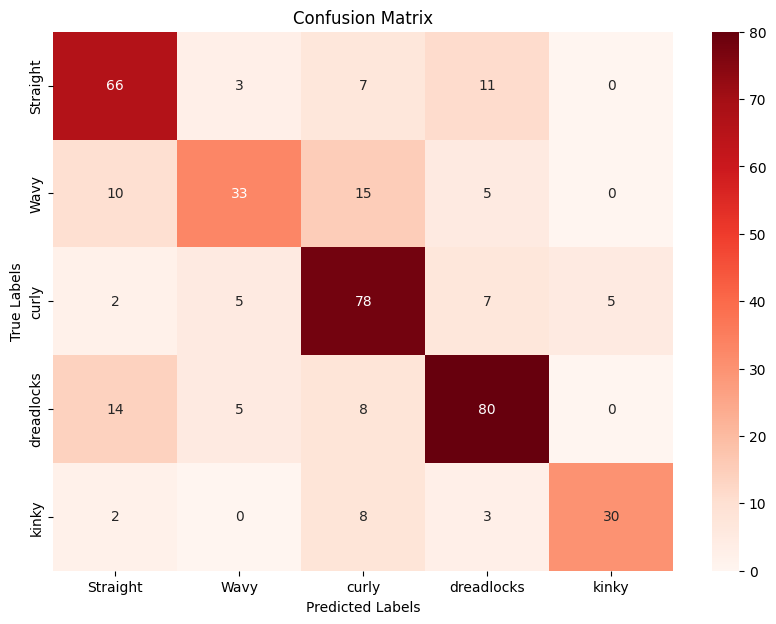

In [14]:


# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Conclusion

In this notebook, we successfully implemented a hair style type recognition model using the VGG16 architecture. We started by importing the necessary images from Kaggle and preprocessing them to ensure compatibility with our model. We then divided the dataset into training and testing sets and applied data augmentation techniques to enhance the robustness of our model.

Using the VGG16 model with pretrained weights, we fine-tuned the model by unfreezing some layers and adjusting the learning rate. The model was trained on the augmented dataset, and the best weights were saved during training.

We evaluated the model's performance on the testing set, achieving an accuracy of approximately 72.29%. The confusion matrix provided insights into the classification performance, highlighting areas where the model performed well and areas that may require further improvement.

Overall, this project demonstrates the effectiveness of transfer learning and data augmentation in building a robust image classification model for hair style type recognition. Future work could involve exploring other architectures, further fine-tuning, and expanding the dataset to improve accuracy.